In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pandas as pd
import logging
from tqdm import tqdm
import matplotlib.pyplot as plt
import json

# Add the project root to the system path using the current working directory
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
if project_root not in sys.path:
    sys.path.append(project_root)

# Import using absolute path from project root
from src.instances.chain_instance import ARBITRUM_DTO, OPTIMISM_DTO, ETHEREUM_DTO, BASE_DTO
from src.instances.aave_instance import AaveArbitrum, AaveOptimism, AaveEthereum, AaveBase
from src.models.token import TokenDTO


2024-11-29 17:33:24,536 INFO src.models.aave_protocol Initialized Aave Protocol DTO for network: Arbitrum
2024-11-29 17:33:24,536 INFO src.models.aave_protocol Initialized Aave Protocol DTO for network: Optimism
2024-11-29 17:33:24,537 INFO src.models.aave_protocol Initialized Aave Protocol DTO for network: Ethereum
2024-11-29 17:33:24,538 INFO src.models.aave_protocol Initialized Aave Protocol DTO for network: Base


In [4]:
from src.scripts.process_stored_data_aave import update_trade_pair_exchange_price, \
    create_liquidatable_user_data_series, create_health_ratio_data_emode, create_asset_mapping, \
    create_health_ratio_data, create_liquidatable_user_data, scale_supply_and_create_liquidations, \
    create_liquidations_v2, scale_price_and_identify_liquidatable_collateral


In [5]:
chain_object_mapping = {
    'ethereum': [ETHEREUM_DTO, AaveEthereum],
    'arbitrum': [ARBITRUM_DTO, AaveArbitrum],
    'optimism': [OPTIMISM_DTO, AaveOptimism],
    'base': [BASE_DTO, AaveBase]
}


In [6]:
CHOOSEN_CHAIN = 'ethereum'
AAVE_EMODE_LT = 0.95
ASSET_UNDER_CONSIDERATION = "WETH"

if CHOOSEN_CHAIN not in chain_object_mapping:
    print("Invalid chain chosen.")
    exit(1)
else:
    chain_instance, aave_instance = chain_object_mapping[CHOOSEN_CHAIN]


In [86]:
if not os.path.exists('aave_supported_asset_data.csv'):
    print("File not found. Fetching from RPC.")
    aave_supported_asset_data = aave_instance.get_aave_supported_asset_data()
    print("Saving to file.")
    aave_supported_asset_data.to_csv('aave_supported_asset_data.csv', index=False)
else:
    print("File found. Reading from file.")
    aave_supported_asset_data = pd.read_csv('aave_supported_asset_data.csv')


File not found. Fetching from RPC.
Saving to file.


In [8]:
if not os.path.exists('aave_user_position_data.csv'):
    print("File not found. Fetching from RPC.")
    aave_user_position_data = aave_instance.get_user_position_data(aave_supported_asset_data)
    print("Saving to file.")
    aave_user_position_data.to_csv('aave_user_position_data.csv', index=False)
else:
    print("File found. Reading from file.")
    aave_user_position_data = pd.read_csv('aave_user_position_data.csv')


File found. Reading from file.


In [87]:
aave_asset_object_dict = {}

for _, row in tqdm(aave_supported_asset_data.iterrows(), total=len(aave_supported_asset_data), desc="Creating TokenDTO objects"):
    token = TokenDTO(
        address=row['assetAddress'],
        name=row['symbol'],
        symbol=row['symbol'],
        decimals=row['decimals'],
        chain=chain_instance,
        price=row['price'],
    )
    aave_asset_object_dict[row['symbol']] = token

Creating TokenDTO objects:   0%|          | 0/37 [00:00<?, ?it/s]

Creating TokenDTO objects: 100%|██████████| 37/37 [00:09<00:00,  3.70it/s]


In [10]:
current_price_mapping = {}
for index, asset in aave_supported_asset_data.iterrows():
    current_price_mapping[asset['symbol']] = asset['price']

In [60]:
liquidatable_price_df = scale_price_and_identify_liquidatable_collateral(aave_supported_asset_data, 
                                                            aave_user_position_data, 
                                                            current_price_mapping, 
                                                            AAVE_EMODE_LT, 
                                                            ASSET_UNDER_CONSIDERATION,
                                                            0.5, 
                                                            30)



Scaling WETH price: 100%|██████████| 30/30 [03:43<00:00,  7.44s/scale]


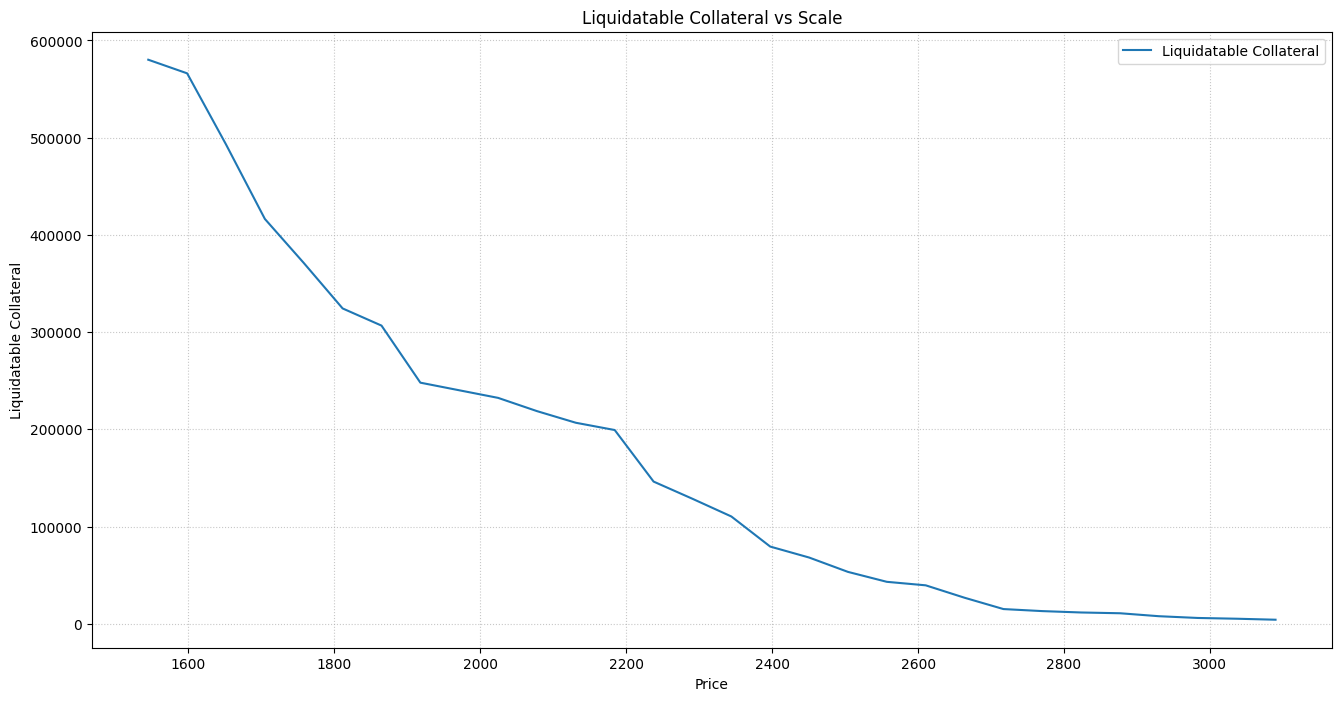

In [13]:
# plot scale and liquidatable_collateral
plt.figure(figsize=(16, 8))
plt.plot(liquidatable_price_df['price'], liquidatable_price_df['liquidatable_collateral'], label='Liquidatable Collateral')
plt.xlabel('Price')
plt.ylabel('Liquidatable Collateral')
plt.title('Liquidatable Collateral vs Scale')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

## Curve user positions

In [27]:
from src.instances.curve_mint_market_instance import market_objects_dict


In [111]:
ASSET_UNDER_CONSIDERATION_CURVE = 'WETH'


In [28]:
market = market_objects_dict[ASSET_UNDER_CONSIDERATION_CURVE]
df = market.get_user_position_data()

In [29]:
output_liq_df = market.compute_price_for_max_hard_liq(df, 0.85)

In [30]:
output_liq_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   max_price             10 non-null     float64
 1   max_collateral_value  10 non-null     float64
 2   debt                  10 non-null     float64
dtypes: float64(3)
memory usage: 372.0 bytes


In [69]:
# Convert liquidatable_price_df's cumulative values to absolute values
liquidatable_price_abs_df = liquidatable_price_df.copy()
liquidatable_price_abs_df = liquidatable_price_abs_df.sort_values('price', ascending=True)  # Sort ascending first
liquidatable_price_abs_df = liquidatable_price_abs_df.reset_index(drop=True)  # Reset index after sorting

# Calculate differences from bottom up
liquidatable_price_abs_df['liquidatable_collateral_abs'] = liquidatable_price_abs_df['liquidatable_collateral'].diff(-1)
# Fill the last row with its liquidatable_collateral value since it's the base value
liquidatable_price_abs_df.loc[liquidatable_price_abs_df.index[-1], 'liquidatable_collateral_abs'] = liquidatable_price_abs_df.loc[liquidatable_price_abs_df.index[-1], 'liquidatable_collateral']

# Sort back to descending order for the rest of the processing
liquidatable_price_abs_df = liquidatable_price_abs_df.sort_values('price', ascending=False)
liquidatable_price_abs_df = liquidatable_price_abs_df.reset_index(drop=True)

# Create new dataframes with renamed columns for clarity
df1 = output_liq_df[['max_price', 'max_collateral_value']].rename(
    columns={'max_price': 'price', 'max_collateral_value': 'liquidatable_collateral_abs'})
df2 = liquidatable_price_abs_df[['price', 'liquidatable_collateral_abs']]

# Concatenate the dataframes
combined_df = pd.concat([df1, df2], ignore_index=True)

# Sort by price in descending order
combined_df = combined_df.sort_values('price', ascending=False)

# Create cumulative sum column
combined_df['cumulative_liquidatable_collateral'] = combined_df['liquidatable_collateral_abs'].cumsum()

# Reset index after sorting
combined_df = combined_df.reset_index(drop=True)

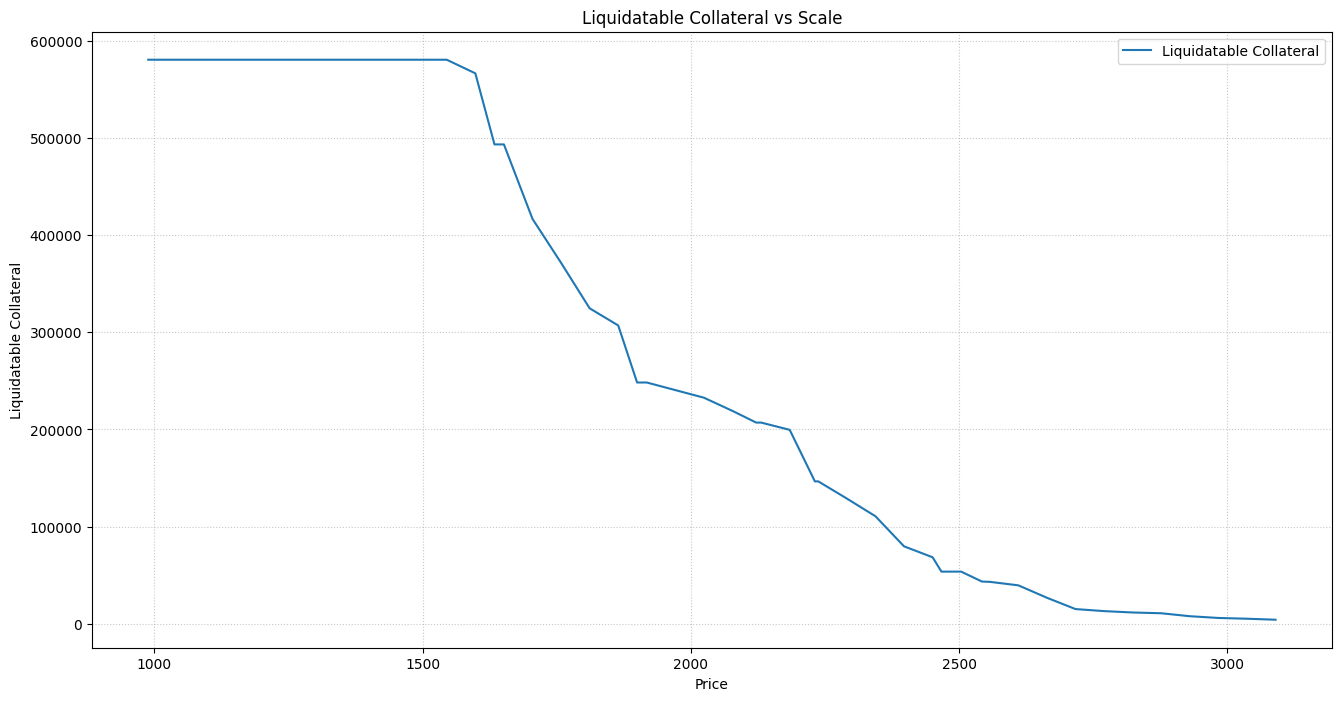

In [71]:
# plot scale and liquidatable_collateral
plt.figure(figsize=(16, 8))
plt.plot(combined_df['price'], combined_df['cumulative_liquidatable_collateral'], label='Liquidatable Collateral')
plt.xlabel('Price')
plt.ylabel('Liquidatable Collateral')
plt.title('Liquidatable Collateral vs Scale')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

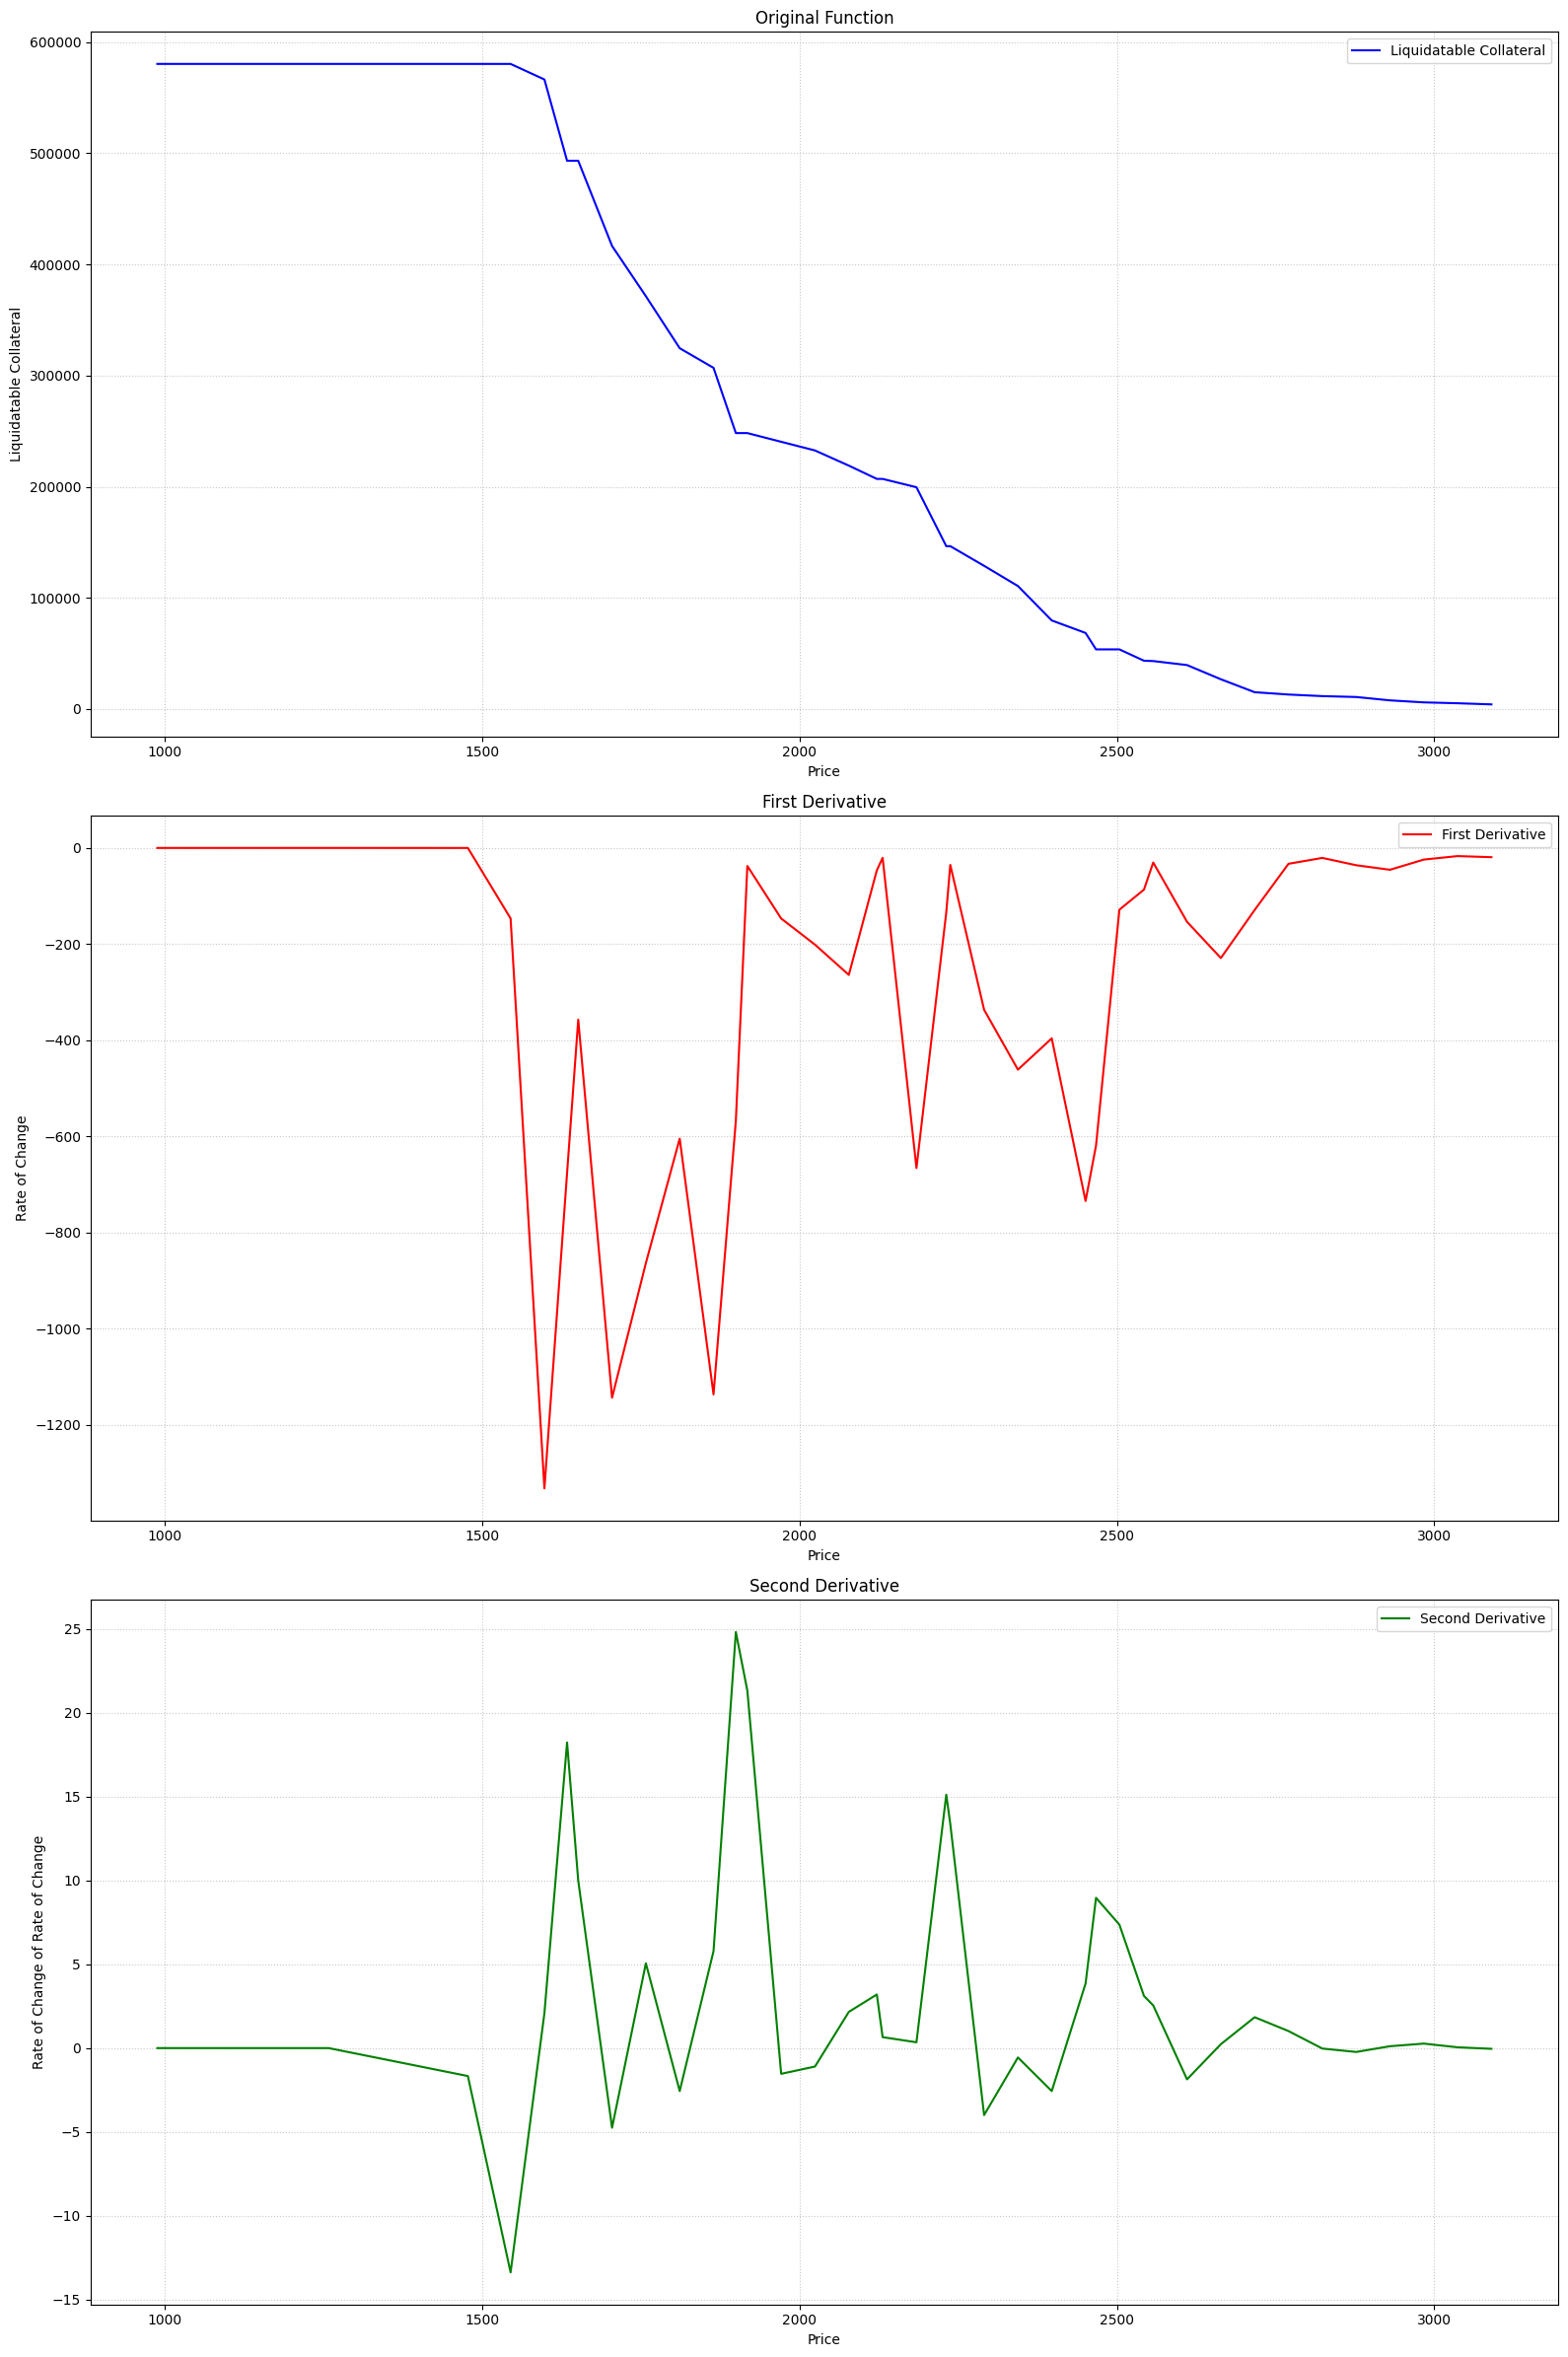

In [73]:
import numpy as np

# Calculate first and second derivatives
first_derivative = np.gradient(combined_df['cumulative_liquidatable_collateral'], combined_df['price'])
second_derivative = np.gradient(first_derivative, combined_df['price'])

# Create subplots
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(16, 24))

# Plot original function
ax1.plot(combined_df['price'], combined_df['cumulative_liquidatable_collateral'], 'b-', label='Liquidatable Collateral')
ax1.set_xlabel('Price')
ax1.set_ylabel('Liquidatable Collateral')
ax1.set_title('Original Function')
ax1.grid(True, linestyle=':', alpha=0.7)
ax1.legend()

# Plot first derivative
ax2.plot(combined_df['price'], first_derivative, 'r-', label='First Derivative')
ax2.set_xlabel('Price')
ax2.set_ylabel('Rate of Change')
ax2.set_title('First Derivative')
ax2.grid(True, linestyle=':', alpha=0.7)
ax2.legend()

# Plot second derivative
ax3.plot(combined_df['price'], second_derivative, 'g-', label='Second Derivative')
ax3.set_xlabel('Price')
ax3.set_ylabel('Rate of Change of Rate of Change')
ax3.set_title('Second Derivative')
ax3.grid(True, linestyle=':', alpha=0.7)
ax3.legend()

plt.tight_layout()
plt.show()

---

In [88]:
# Find value from aave_asset_object_dict where the key is the same as ASSET_UNDER_CONSIDERATION
asset_object = next((value for key, value in aave_asset_object_dict.items() if key == ASSET_UNDER_CONSIDERATION), None)


In [102]:
PRICE_ASSUMPTION = 0.85*asset_object.price


In [114]:
def get_curve_liquidation_data(output_liq_df: pd.DataFrame, price_assumption: float) -> tuple[float, float]:
    """
    Get curve liquidation data for the closest price point >= price_assumption.
    Returns (collateral, debt) tuple or (None, None) if no suitable price found.
    """
    # Check if there are any prices >= price_assumption
    valid_rows = output_liq_df[output_liq_df['max_price'] <= price_assumption]
    
    if valid_rows.empty:
        return None, None
    
    # Get the closest row
    closest_row = valid_rows.sort_values('max_price').iloc[-1]
    return {ASSET_UNDER_CONSIDERATION_CURVE:float(closest_row['max_collateral_value'])}, {'crvUSD':float(closest_row['debt'])}


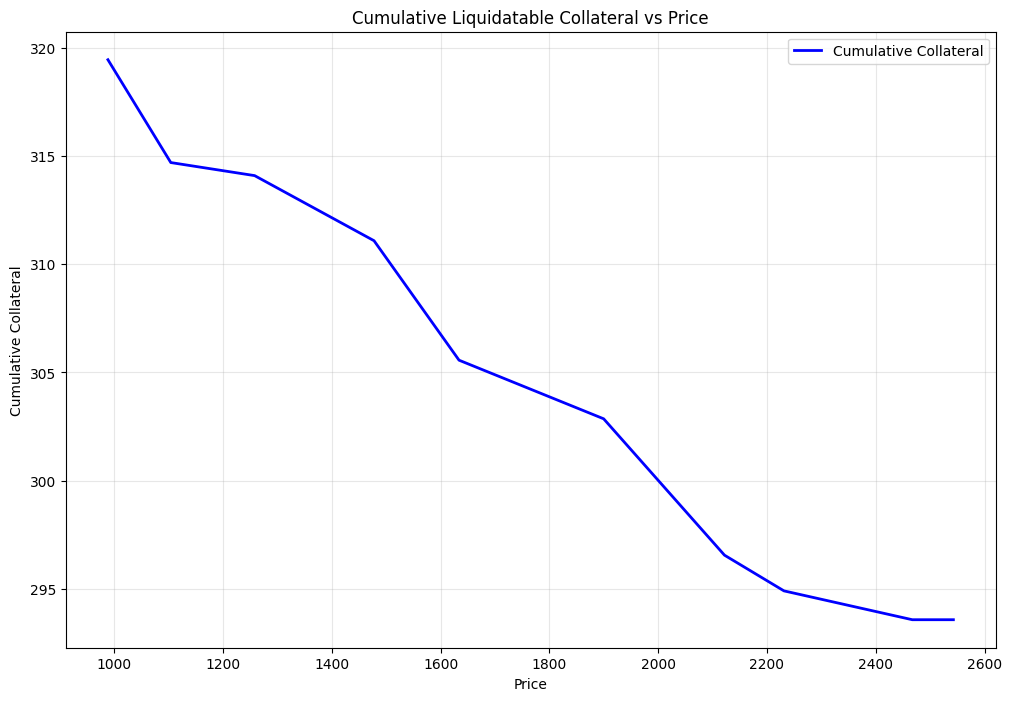

In [104]:
# Create a copy and sort by max_price in descending order
plot_df = output_liq_df.copy()
plot_df = plot_df.sort_values('max_price', ascending=False)

# Add cumulative sum column
plot_df['cum_collateral'] = plot_df['max_collateral_value'].cumsum()

plot_df['cum_debt'] = plot_df['debt'].cumsum()

# Create the plot
plt.figure(figsize=(12, 8))
plt.plot(plot_df['max_price'], plot_df['cum_collateral'], 
         label='Cumulative Collateral', 
         color='blue',
         linewidth=2)

plt.xlabel('Price')
plt.ylabel('Cumulative Collateral')
plt.title('Cumulative Liquidatable Collateral vs Price')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

In [115]:
curve_collateral, curve_debt = get_curve_liquidation_data(output_liq_df, PRICE_ASSUMPTION)

In [94]:
def analyze_liquidatable_positions(
    aave_supported_asset_data: pd.DataFrame,
    aave_user_position_data: pd.DataFrame,
    asset_under_consideration: str,
    price_assumption: float,
    emode_lt: float,
    min_usd_threshold: float = 10000
) -> dict:
    """
    Analyzes liquidatable positions for given asset and price assumption.
    Returns both raw and USD values for liquidatable collateral and debt.
    """
    # Create price mapping
    new_price_mapping = {asset_under_consideration: price_assumption}
    price_mapping = dict(zip(aave_supported_asset_data['symbol'], aave_supported_asset_data['price']))
    
    # Create asset mapping and get health ratios
    asset_mapping = create_asset_mapping(aave_supported_asset_data, new_price_mapping)
    
    # Get health ratio data for both normal and emode
    health_ratio_data_no_emode = create_health_ratio_data(aave_user_position_data, asset_mapping)
    health_ratio_data_emode = create_health_ratio_data_emode(aave_user_position_data, asset_mapping, emode_lt)
    health_ratio_data = pd.concat([health_ratio_data_no_emode, health_ratio_data_emode])
    
    # Get liquidatable positions
    total_liquidatable_collateral, total_liquidatable_debt = create_liquidatable_user_data(health_ratio_data)
    
    # Filter non-zero positions
    total_liquidatable_collateral = {k: v for k, v in total_liquidatable_collateral.items() if v > 0}
    total_liquidatable_debt = {k: v for k, v in total_liquidatable_debt.items() if v > 0}
    
    # Convert to USD
    total_liquidatable_collateral_usd = {
        symbol: quantity * price_mapping.get(symbol, 1)
        for symbol, quantity in total_liquidatable_collateral.items()
    }
    
    total_liquidatable_debt_usd = {
        symbol: quantity * price_mapping.get(symbol, 1)
        for symbol, quantity in total_liquidatable_debt.items()
    }
    
    # Filter by USD threshold
    filtered_collateral_usd = {k: v for k, v in total_liquidatable_collateral_usd.items() if v > min_usd_threshold}
    filtered_debt_usd = {k: v for k, v in total_liquidatable_debt_usd.items() if v > min_usd_threshold}
    
    # Reconstruct raw values from filtered USD values
    filtered_collateral = {
        symbol: float(usd_value) / price_mapping.get(symbol, 1)
        for symbol, usd_value in filtered_collateral_usd.items()
    }
    
    filtered_debt = {
        symbol: float(usd_value) / price_mapping.get(symbol, 1)
        for symbol, usd_value in filtered_debt_usd.items()
    }
    
    return filtered_collateral, filtered_debt

In [118]:
aave_collateral, aave_debt = analyze_liquidatable_positions(
    aave_supported_asset_data,
    aave_user_position_data,
    ASSET_UNDER_CONSIDERATION,
    PRICE_ASSUMPTION,
    AAVE_EMODE_LT
)

aave_collateral

{'WETH': 7748.708676917095,
 'wstETH': 6.57618537289123,
 'WBTC': 13.55443767,
 'AAVE': 605.7608362897674,
 'ETHx': 9.621399850846554}

In [119]:
def merge_liquidation_data(aave_data: dict, curve_data: dict) -> dict:
    """
    Merge liquidation data from Aave and Curve protocols.
    """
    merged_data = aave_data.copy()  # Start with Aave data
    
    # Merge Curve data
    for token, amount in curve_data.items():
        if token in merged_data:
            merged_data[token] += amount
        else:
            merged_data[token] = amount
    
    return merged_data


In [120]:
# Merge collateral data
total_collateral = merge_liquidation_data(aave_collateral, curve_collateral)

# Merge debt data
total_debt = merge_liquidation_data(aave_debt, curve_debt)

print("Total Liquidatable Collateral:")
print(json.dumps(total_collateral, indent=4))
print("\nTotal Liquidatable Debt:")
print(json.dumps(total_debt, indent=4))

Total Liquidatable Collateral:
{
    "WETH": 8042.288676917095,
    "wstETH": 6.57618537289123,
    "WBTC": 13.55443767,
    "AAVE": 605.7608362897674,
    "ETHx": 9.621399850846554
}

Total Liquidatable Debt:
{
    "WETH": 9.369214259821442,
    "wstETH": 1887.1996703294296,
    "WBTC": 0.22381784,
    "USDC": 2671619.258961,
    "cbETH": 236.1577270885336,
    "USDT": 8735503.661896002,
    "rETH": 247.2120344396576,
    "GHO": 16240.859328298819,
    "RPL": 2266.3523831794855,
    "weETH": 932.1435032457356,
    "osETH": 9.52752104757144,
    "ETHx": 3.8355438581251393,
    "crvUSD": 1700005.3762033915
}


In [22]:
import requests
from typing import Dict, Optional
import logging

def fetch_curve_market_data(
    network: str = "ethereum",
    page: int = 1,
    per_page: int = 10,
    fetch_on_chain: bool = False
) -> Optional[Dict]:
    """
    Fetch market data from Curve Finance API.
    
    Args:
        network (str): Network name (default: "ethereum")
        page (int): Page number for pagination (default: 1)
        per_page (int): Number of items per page (default: 10)
        fetch_on_chain (bool): Whether to fetch on-chain data (default: False)
        
    Returns:
        Optional[Dict]: JSON response from the API or None if request fails
    """
    
    base_url = "https://prices.curve.fi/v1/crvusd/markets"
    
    try:
        # Construct URL with query parameters
        url = f"{base_url}/{network}"
        params = {
            "fetch_on_chain": str(fetch_on_chain).lower(),
            "page": page,
            "per_page": per_page
        }
        
        # Make the request
        response = requests.get(url, params=params, timeout=10)
        response.raise_for_status()  # Raise exception for non-200 status codes
        
        return response.json()['data']
        
    except requests.RequestException as e:
        logging.error(f"Error fetching Curve market data: {str(e)}")
        return None

In [23]:
# Example usage
market_data = fetch_curve_market_data(
    network="ethereum",
    page=1,
    per_page=10,
    fetch_on_chain=False
)

if market_data:
    print(json.dumps(market_data, indent=4))
else:
    print("Failed to fetch market data")

[
    {
        "address": "0xA920De414eA4Ab66b97dA1bFE9e6EcA7d4219635",
        "factory_address": "0xC9332fdCB1C491Dcc683bAe86Fe3cb70360738BC",
        "llamma": "0x1681195C176239ac5E72d9aeBaCf5b2492E0C4ee",
        "rate": 0.15547447873003417,
        "total_debt": 23856229.94088477,
        "n_loans": 332,
        "debt_ceiling": null,
        "borrowable": 176145282.15854222,
        "pending_fees": 1512.0994269523942,
        "collected_fees": 4218729.870460187,
        "collateral_amount": 13520.629497772195,
        "collateral_amount_usd": 48495794.70795941,
        "stablecoin_amount": 537980.9215038663,
        "collateral_token": {
            "symbol": "WETH",
            "address": "0xC02aaA39b223FE8D0A0e5C4F27eAD9083C756Cc2"
        },
        "stablecoin_token": {
            "symbol": "crvUSD",
            "address": "0xf939E0A03FB07F59A73314E73794Be0E57ac1b4E"
        }
    },
    {
        "address": "0xEC0820EfafC41D8943EE8dE495fC9Ba8495B15cf",
        "factory_addr